In [435]:
import numpy as np
import matplotlib.pyplot as plt

## Data generation

In [436]:
# Good, but 2 CLASSES ONLY
#   alpha increases "spread"
#   beta increases "jitter"
def generate_data(n, alpha=0.1, beta=1, initial_point=[0, 0], groups=[0, 1], add_bias=True):
    data = np.empty((n, 2))
    # Define an initial point
    data[0, :] = initial_point
    
    # Randomly "scale" the upcoming reflection
    a = np.random.uniform(low=(-1-alpha), high=(-1+alpha), size=n)
    
    # "Flip" previous point and add some noise
    for k in range(1, n):
        data[k, ] = a[k]*data[k-1, :] + beta*np.random.normal(0, 1, size=2)
    
    # Add a bias variable
    if add_bias:
        data = np.hstack((np.ones((n, 1)), data))
    
    # Labels are two classes (0, 1), strictly alternating, because of "flipping" above
    labs = np.array(groups*(n//2 + 1))[:n]
    
    return data, labs

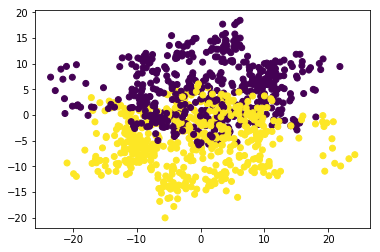

In [437]:
demo_data, demo_labs = generate_data(1000, initial_point=[10, 10])

plt.scatter(demo_data[:, 1], demo_data[:, 2], c=demo_labs)

## Auxiliary functions

In [639]:
def make_sets(data, props):
    if sum(props) != 1:
        raise ValueError("proportions must sum to 1")
    
    m = data.shape[0]
    
    sets = []
    cursor = 0
    
    for p in props:
        s = data[cursor:(cursor+int(p*m)), :]
        sets.append(s)
        cursor = int(p*m)
    
    return sets

In [642]:
ss = make_sets(demo_data, [0.6, 0.2, 0.2])

In [643]:
[s.shape for s in ss]

[(600, 3), (200, 3), (200, 3)]

In [438]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [439]:
sigmoid(1)

0.7310585786300049

In [440]:
def predict(features, weights):
    Z = np.dot(features, weights)
    return sigmoid(Z)

In [441]:
# Must initialise weights to be different
# Otherwise complete cancellation can lead to failure
init_weights = np.random.uniform(-0.01, 0.01, 3)

In [442]:
pp = predict(demo_data, init_weights)
pp.shape, pp.sum()

((1000,), 502.0880722683073)

In [443]:
def classify(predictions, threshold=0.5):
    return (predictions >= threshold).astype(int)

In [444]:
classify(pp)[:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [467]:
def accuracy(predicted, actual):
    return np.mean(predicted == actual)

In [469]:
def plot_boundary(data, labels, weights, subdivs=200, alpha=0.2):
    
    fig, ax = plt.subplots()
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    
    xmin, xmax = ax.get_xlim()
    xstep = (xmax-xmin)/subdivs
    ymin, ymax = ax.get_ylim()
    ystep = (ymax-ymin)/subdivs
    
    grid = np.mgrid[xmin:xmax:xstep, ymin:ymax:ystep].reshape(2, -1).T
    n = grid.shape[0]
    grid_with_bias = np.hstack((np.ones((n, 1)), grid))
    
    ax.contourf(np.arange(xmin, xmax, xstep), np.arange(ymin, ymax, ystep),
               predict(grid_with_bias, weights).reshape(-1, subdivs).T,
               alpha = alpha)
    
    ax.scatter(data[:, 1], data[:, 2], c=labels)
    return None

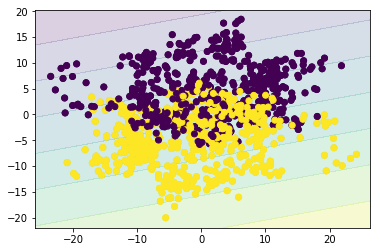

In [472]:
plot_boundary(demo_data, demo_labs, init_weights)

## Simple logistic regression

In [445]:
def get_cost(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Log-loss cost function
    cost = -(labels*np.log(preds) + (1-labels)*np.log(1-preds)).sum()
    
    # Average cost per observation
    return cost/m
    

In [446]:
get_cost(demo_data, demo_labs, init_weights)

0.6830580955226138

In [447]:
def get_grad(features, labels, weights):
    
    m = features.shape[0]
    preds = predict(features, weights)
    
    # Average gradient over all observations
    grad = np.dot(features.T, (preds - labels)) / m
    
    return grad

In [448]:
get_grad(demo_data, demo_labs, init_weights)

array([2.08807227e-03, 7.51013464e-01, 2.35390630e+00])

In [ ]:
def get_rate(k, prev_rate, rate_method):
    rate_method(k, prev_rate, 

In [622]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        weights = weights - rate*grad
        
        new_cost = get_cost(features, labels, weights)
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [582]:
opt_weights, ch = train(demo_data, demo_labs, init_weights, iters=2000, report_level=10)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.6830580955226138
0010 | 0.3875667173859347
0020 | 0.38737237912728845
Tolerance reached - terminating early!

Training complete!
Iterations completed: 22
Final cost: 0.3873711643959368


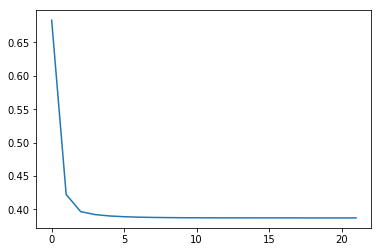

In [583]:
plt.plot(ch)

In [584]:
opt_weights

array([ 0.00607175, -0.01993122, -0.36554144])

In [585]:
preds = predict(demo_data, opt_weights)
preds_classes = classify(preds)

accuracy(preds_classes, demo_labs)

0.786

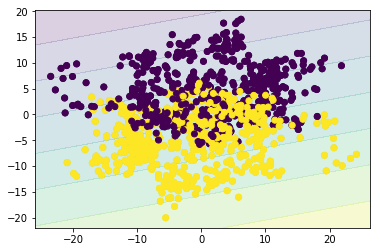

In [586]:
plot_boundary(demo_data, demo_labs, init_weights)

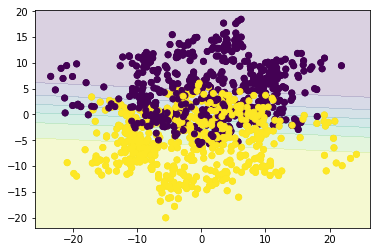

In [587]:
plot_boundary(demo_data, demo_labs, opt_weights)

## Variable step size

Two approaches:

* Decrease at a set rate (e.g. exponential decay)
* Adaptive decrease (e.g. backtracking)

Second approach is perhaps more expensive, but mitigated if we assume that step size **decreases** as we approach the optimum. Offers more flexibility.

In [623]:
def train(features, labels, init_weights, iters=1000, rate=0.1, tolerance=1e-6, verbose=True, report_level=100):

    cost = get_cost(features, labels, init_weights)
    
    if verbose:
        print("Training in progress...")
        print("")
        print("Iter | Cost")
        print("---- | ----")
        print("0000 |", cost)

    cost_history = np.empty(iters+1)
    cost_history[0] = cost
    weights = init_weights[:]
    
    for k in range(1, iters+1):
        
        # Update weights based on gradient of cost function
        grad = get_grad(features, labels, weights)
        
        new_weights = weights - rate*grad
        new_cost = get_cost(features, labels, new_weights)
         
        while new_cost > cost:
            if verbose:
                print("  Rate change!", rate, "->", rate/2)
            rate = rate/2
            new_weights = weights - rate*grad
            new_cost = get_cost(features, labels, new_weights)
        
        weights = new_weights
        
        # Stopping criterion
        if abs(cost - new_cost) < tolerance:
            if verbose:
                print("Tolerance reached - terminating early!")
            
            cost_history = cost_history[:k]
            break
            
        else:        
            cost = new_cost
            cost_history[k] = cost
        
            if verbose and k % report_level == 0:
                print(str(k).zfill(4), "|", cost)
    
    if verbose:
        print("")
        print("Training complete!")
        print("Iterations completed:", k)
        print("Final cost:", cost_history[-1])
    
    return weights, cost_history

In [624]:
optw, ch = train(demo_data, demo_labs, init_weights, rate=0.5, iters=2000, report_level=5)

Training in progress...

Iter | Cost
---- | ----
0000 | 0.6830580955226138
  Rate change! 0.5 -> 0.25
0005 | 0.40347736013361396
  Rate change! 0.25 -> 0.125
0010 | 0.38786761813368104
0015 | 0.3874158999195321
0020 | 0.3873722284132322
Tolerance reached - terminating early!

Training complete!
Iterations completed: 23
Final cost: 0.38736956357080715


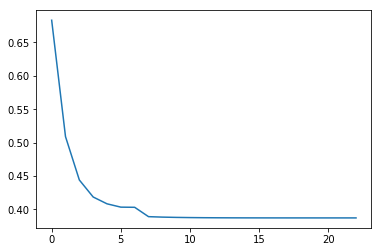

In [625]:
plt.plot(ch)